In [ ]:
Importing kp

Dataset Loading 

In [1]:
!pip install tensorflow-datasets

import tensorflow_datasets as tfds

(ds_train, ds_test), ds_info = tfds.load(
    'beans',
    split=['train', 'test'],
    as_supervised=True,
    with_info=True
)


### Data Visualization 

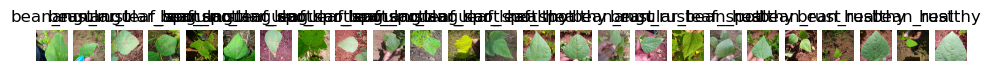

In [11]:
import matplotlib.pyplot as plt
# Define a function to plot the images with labels
def plot_images(ds, num_images=5):
    plt.figure(figsize=(12, 12))
    class_names = ds_info.features['label'].names  # Get the class names from ds_info
    
    # Take 'num_images' from the dataset and plot them
    for i, (image, label) in enumerate(ds.take(num_images)):
        ax = plt.subplot(1, num_images, i + 1)
        plt.imshow(image)
        plt.title(class_names[label.numpy()])
        plt.axis("off")

# Visualize 5 images from the training dataset
plot_images(ds_train, num_images=25)
plt.show()

Data Preprocessing 

In [23]:
import tensorflow as tf
# Function to resize and normalize the images
def preprocess_image(image, label):
    image = tf.image.resize(image, [224, 224])  # Resize to 224x224
    image = image / 255.0  # Normalize the pixel values to [0, 1]
    return image, label

# Apply the preprocessing to the dataset
ds_train_resized = ds_train.map(preprocess_image)
ds_test_resized = ds_test.map(preprocess_image)

# Batch the datasets (optional)
ds_train_resized = ds_train_resized.batch(32)
ds_test_resized = ds_test_resized.batch(32)


### Model Setup for Transfer Learning

In [30]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Load the MobileNetV2 model with pre-trained ImageNet weights, excluding the top layers
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),  # Input shape as expected by MobileNetV2
    include_top=False,          # Exclude the fully connected layer at the top
    weights='imagenet'          # Use pre-trained ImageNet weights
)

# Freeze all layers in the base model
base_model.trainable = False

# Create a new model by adding custom classification layers on top
model = models.Sequential([
    base_model,  # Base model (frozen)
    layers.GlobalAveragePooling2D(),  # Reduce dimensions while keeping global information
    layers.Dense(128, activation='relu'),  # A dense layer for further feature extraction
    layers.Dropout(0.5),  # Dropout for regularization
    layers.Dense(3, activation='softmax')  # Final layer with 3 units for 3 classes
])

## Training the Model 

In [32]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping


# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Set up Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    ds_train_resized,
    validation_data=ds_test_resized,
    epochs=50,  # Set a high number, but early stopping will stop if no improvement
    batch_size=32,  # Batch size of 32, commonly used in CNNs
    callbacks=[early_stopping]
)

Epoch 1/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 24s 536ms/step - accuracy: 0.5366 - loss: 1.0376 - val_accuracy: 0.8672 - val_loss: 0.3832
Epoch 2/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 15s 469ms/step - accuracy: 0.8388 - loss: 0.3974 - val_accuracy: 0.8984 - val_loss: 0.3114
Epoch 3/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 15s 459ms/step - accuracy: 0.8951 - loss: 0.2853 - val_accuracy: 0.8984 - val_loss: 0.2932
Epoch 4/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 15s 463ms/step - accuracy: 0.9167 - loss: 0.2269 - val_accuracy: 0.9062 - val_loss: 0.2433
Epoch 5/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - accuracy: 0.9298 - loss: 0.1968 - val_accuracy: 0.8984 - val_loss: 0.2508
Epoch 6/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 15s 455ms/step - accuracy: 0.9349 - loss: 0.1607 - val_accuracy: 0.8828 - val_loss: 0.2548
Epoch 7/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 19s 411ms/step - accuracy: 0.9441 - loss: 0.1415 - val_accuracy: 0.9141 - val_loss: 0.2170
Epoch 8/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 14s 424ms/step - accuracy: 0.9583 - loss: 0.1233 - val_accu

### Model Evaluation 

In [35]:
from sklearn.metrics import classification_report
import numpy as np

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(ds_test_resized)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Predict the labels for the test set
y_true = []
y_pred = []

# Iterate over the test dataset to get true and predicted labels
for images, labels in ds_test_resized:
    predictions = model.predict(images)
    y_true.extend(labels.numpy())  # Actual labels
    y_pred.extend(np.argmax(predictions, axis=1))  # Predicted labels

# Generate a classification report for precision, recall, and F1-score
class_names = ds_info.features['label'].names  # The names of the classes

print(classification_report(y_true, y_pred, target_names=class_names))


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 260ms/step - accuracy: 0.9052 - loss: 0.1890
Test Loss: 0.18682661652565002
Test Accuracy: 0.9140625
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step
                   precision    recall  f1-score   support

angular_leaf_spot       0.89      0.93      0.91        43
        bean_rust       0.88      0.86      0.87        43
          healthy       0.98      0.95      0.96        42

         accuracy                           0.91       128
        macro avg       0.92      0.91      0.91       128
     weighted avg       0.91      0.91      0.91       128



### Model Saving and Reusability 

In [39]:
# Save the trained model in ".keras" format
model.save('beans_classification_model.keras')
# Load the saved model
from tensorflow.keras.models import load_model

model = load_model('beans_classification_model.keras')

# Verify that the model is correctly loaded
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,751,051 (10.49 MB)

 Trainable params: 164,355 (642.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 328,712 (1.25 MB)